In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import math
from heateq import Exact, Simulateur

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [5]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.916465294707976
33.03617206344313


# Espérance $\mu_Z$ inconnue

On considère que $\mu_Z$ n'est pas connue.

## Expérience pilote

Estimer $\alpha^*$, $\rho^2$ et $\tau^*$ à l'aide de `ns = 10000` échantillons pilotes, et en déduire une estimation de $\beta=(1+w \tau^*)^2(1-\rho^2)$ (rapport de variance) dans le cas où $\mu_Z$ est inconnue et comparer à $\beta=(1+w)(1-\rho^2)$ dans le cas où $\mu_Z$ est connue (on suppose $w=1/35$).

In [6]:
w = 1 / 35 # poids de la solution haute fidélité
ns = 10000 # échantillons pilotes
X = n_echantillon_X(ns)

# Calculer les échantillons de Y et Z (haute et basse fidélité)
Y = f(X)
Z = g(X)

# Estimer rho^2
rho2 = np.cov(Y, Z)[0, 1]**2 / (np.var(Y) * np.var(Z))
print("Rho^2 : ", rho2)

# Estimer tau*
tau_star = np.sqrt(rho2 / (w * (1 - rho2)))
print("Tau* : ", tau_star)

# Estimer alpha*
alpha_star = (1 - (1 / tau_star)) * np.cov(Y, Z)[0, 1] / np.var(Z)
print("Alpha* : ", alpha_star)

# Estimer beta (cas moyenne connue)
beta_known = (1 + w*tau_star)**2 * (1 - rho2)
print("Beta (cas moyenne connue) : ", beta_known)

# Estimer beta (cas moyenne inconnue)
beta_unknown = (1 + w)*(1 - rho2)
print("Beta (cas moyenne inconnue) : ", beta_unknown)

# Afficher le rapport de variance
print("Rapport de variance : ", beta_known / beta_unknown)

Rho^2 :  0.981130688390346
Tau* :  42.65985981132006
Alpha* :  0.98169849706706
Beta (cas moyenne connue) :  0.09289945630674694
Beta (cas moyenne inconnue) :  0.01940843479850125
Rapport de variance :  4.78655065548721


## Estimateur ACV

Utiliser la valeur de $\alpha^*$ estimée précédemment (avec des échantillons pilotes) pour contruire un estimateur par variable de contrôle pour l'espérance de $Y$. 
Faire `nr = 1000` répétitions pour des budgets (en termes de nombre d'évaluations haute fidélité équivalentes) $\tilde{n}_f = c / c_f \in \{5; 10; 20; 50; 100; 200; 500; 1000\}$.

Estimer la réduction de variance à budget équivalent entre l'estimateur par variable de contrôle et l'estimateur Monte Carlo classique (haute fidélité). Est-elle conforme à la valeur de $\beta$ calculée précédemment ?

Tracer l'espérance et l'écart-type (sous forme de barres d'erreur) des estimateurs par variable de contrôle et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}_f$. Sur un autre graphe, tracer l'évolution de la REQM des estimateurs en fonction de $\tilde{n}_f$.

In [7]:
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000]

In [8]:
import matplotlib.pyplot as plt

In [9]:
# Stockage des résultats
means_mc = np.zeros(len(budgets))  # Moyenne des estimateurs Monte Carlo
stds_mc = np.zeros(len(budgets))   # Écart-type des estimateurs Monte Carlo

means_acv = np.zeros(len(budgets))  # Moyenne des estimateurs ACV
stds_acv = np.zeros(len(budgets))   # Écart-type des estimateurs ACV

reqm_mc = np.zeros(len(budgets))  # REQM pour Monte Carlo
reqm_acv = np.zeros(len(budgets))  # REQM pour ACV

for i, budget in enumerate(budgets):
    # Calculer n
    n = int(budget / (1 + w * tau_star))
    N = int(tau_star - 1) * n
    print("Budget : ", budget)
    print("n : ", n)
    print("N : ", N)
    
    mc_estimates = np.zeros(nr)
    acv_estimates = np.zeros(nr)

    for j in range(nr):
        # Echantillons pour Monte Carlo
        X = n_echantillon_X(budget)
        Y = f(X)
        mc_estimates[j] = np.mean(Y)

        # Echantillons pour ACV
        X_f = n_echantillon_X(n)
        X_g = n_echantillon_X(N)
        Y_f = f(X_f)
        Z_f = f(X_g)
        Z_g = g(X_g)
        acv_estimates[j] = np.mean(Y_f) + alpha_star * (np.mean(Z_f) - np.mean(Z_g))
        
    # Calculer les moyennes et écart-types
    means_mc[i] = np.mean(mc_estimates)
    stds_mc[i] = np.std(mc_estimates)
    
    means_acv[i] = np.mean(acv_estimates)
    stds_acv[i] = np.std(acv_estimates)
    
    # Calculer les REQM
    reqm_mc[i] = np.sqrt(np.mean((np.array(mc_estimates) - mu_exact)**2))
    reqm_acv[i] = np.sqrt(np.mean((np.array(acv_estimates) - mu_exact)**2))
    
    print("Monte Carlo : ", means_mc[i], "±", stds_mc[i])
    print("ACV : ", means_acv[i], "±", stds_acv[i])
    print("REQM Monte Carlo : ", reqm_mc[i])
    print("REQM ACV : ", reqm_acv[i])
    print()

Budget :  5
n :  2
N :  82
Monte Carlo :  39.53953267491022 ± 47.63308493269168
ACV :  51.52530065825216 ± 73.52111141408619
REQM Monte Carlo :  47.69579131657582
REQM ACV :  74.1375831269372

Budget :  10
n :  4
N :  164
Monte Carlo :  41.368186031310145 ± 34.41780208117088
ACV :  49.369580088948695 ± 52.94516769233576
REQM Monte Carlo :  34.42331925740181
REQM ACV :  53.457745940327044

Budget :  20
n :  9
N :  369
Monte Carlo :  41.918213411841506 ± 23.8744585029162
ACV :  50.48441433799596 ± 36.35957880271694
REQM Monte Carlo :  23.874550446653743
REQM ACV :  37.339898067058016

Budget :  50
n :  22
N :  902
Monte Carlo :  41.88138141025159 ± 15.413784962688558
ACV :  50.785484128102986 ± 22.83796969635129
REQM Monte Carlo :  15.414129705555284
REQM ACV :  24.475103093332905

Budget :  100
n :  45
N :  1845
Monte Carlo :  41.967211783130296 ± 10.841417953893814
ACV :  51.35460037498213 ± 15.745226449255018
REQM Monte Carlo :  10.841431693821036
REQM ACV :  18.322430477782074

Budge

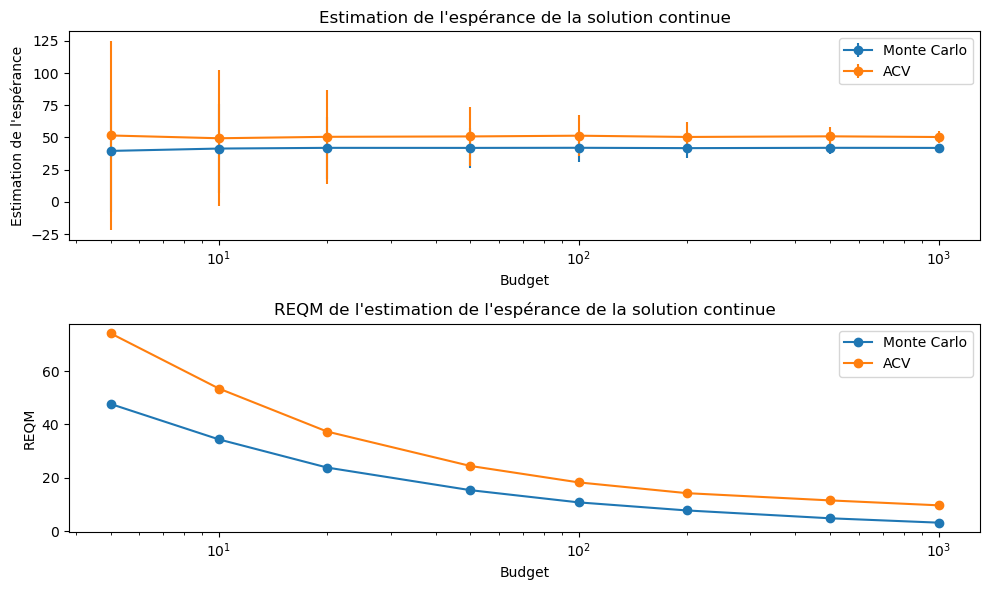

In [10]:
# Afficher les résultats
plt.figure(figsize=(10, 6))

# Graphique des estimateurs
plt.subplot(2, 1, 1)
plt.errorbar(budgets, means_mc, yerr=stds_mc, fmt='o-', label="Monte Carlo")
plt.errorbar(budgets, means_acv, yerr=stds_acv, fmt='o-', label="ACV")
plt.xscale('log')
plt.xlabel("Budget")
plt.ylabel("Estimation de l'espérance")
plt.legend()
plt.title("Estimation de l'espérance de la solution continue")

# Graphique des REQM
plt.subplot(2, 1, 2)
plt.plot(budgets, reqm_mc, 'o-', label="Monte Carlo")
plt.plot(budgets, reqm_acv, 'o-', label="ACV")
plt.xscale('log')
plt.xlabel("Budget")
plt.ylabel("REQM")
plt.legend()
plt.title("REQM de l'estimation de l'espérance de la solution continue")

plt.tight_layout()
plt.show()